In [1]:
import os
import sys
import argparse

import numpy as np
import pandas as pd
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvi
import anndata

import scanpy.external as sce
from scvi.model.utils import mde

from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

import scarches
from scarches.dataset.trvae.data_handling import remove_sparsity
from scarches.models.scpoli import scPoli

/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [3]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(8, 8))

In [4]:
adata = sc.read('../../fetal_lung/lung_organoid_epithelial.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 239440 × 65250
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample_id', 'level_1', 'level_2', 'level_3', 'Cell_type', 'n_counts', 'batch', 'publication'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [6]:
sc.pp.highly_variable_genes(adata,
                            n_top_genes=3000, 
                            batch_key='publication',
                            flavor='seurat_v3', 
                            subset=True)

In [7]:
adata.X[1:10,1:10].toarray()

array([[0., 3., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [8]:
len(set(adata.obs.publication))

12

In [9]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_prototype_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [ ]:
scpoli_model = scPoli(
        adata=adata,
        latent_dim= 30,
        unknown_ct_names=['na'],
        condition_keys=['sample_id'],
        cell_type_keys=['level_2'],
        embedding_dims=10,
        hidden_layer_sizes=[512, 512],
        recon_loss='nb'
    )

scpoli_model.train(
    n_epochs=300,
    pretraining_epochs=4,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=10,
    alpha_epoch_anneal=100
)

In [ ]:
scpoli_model.save("models/scpoli_lung_epithelial_organoid_batch_sampleID_30062023")

### Batch embedding

In [ ]:
conditional_embeddings = scpoli_model.get_conditional_embeddings()
conditional_embeddings

In [ ]:
# add additional metadata, including seq-assay, protocol, aga etc
sample_data = pd.read_table('../../all_samples_sheets.txt')
sample_data.index = sample_data.sample_id
sample_metadata = sample_data.reindex(adata.obs.sample_id.cat.categories)

In [ ]:
mdata = adata.obs
mdata.index = mdata['sample_id'].values
mdata.drop_duplicates(subset = ['sample_id'] ,inplace=True)

In [ ]:
dup_attr = ['publication','sample','sample_id']
sample_metadata.drop(columns = dup_attr, inplace=True)
mdata = pd.concat((mdata, sample_metadata), axis = 1)

In [ ]:
conditional_embeddings.obs = mdata

In [ ]:
sc.pp.pca(conditional_embeddings)

In [ ]:
sc.set_figure_params(figsize=(5, 5))

sc.pl.embedding(conditional_embeddings, 
                basis = 'X_pca',
          components=['1,2'],
          color=['publication','time','derive','tech_detail'], 
                size = 300,
#           ncols=4, 
          ncols=2, 
                legend_fontsize='small',
          wspace = 0.5,
#           legend_loc = 'bottom margin',
#           save = '_sample_embeddings_PC12_Su_covid_allCovidStates.png'
         )

In [ ]:
sc.pl.embedding(conditional_embeddings, 
                basis = 'X_pca',
          components=['3,4'],
          color=['publication',], 
                size = 500,
#           ncols=4, 
          ncols=1, 
#                 legend_fontsize='x-small'
#           wspace = 0.75,
#           legend_loc = 'bottom margin',
#           save = '_sample_embeddings_PC12_Su_covid_allCovidStates.png'
         )

In [ ]:
sc.pl.embedding(conditional_embeddings, 
                basis = 'X_pca',
          components=['5,6'],
          color=['publication',], 
                size = 500,
#           ncols=4, 
          ncols=1, 
#                 legend_fontsize='x-small'
#           wspace = 0.75,
#           legend_loc = 'bottom margin',
#           save = '_sample_embeddings_PC12_Su_covid_allCovidStates.png'
         )

In [ ]:
sc.pl.embedding(conditional_embeddings, 
                basis = 'X_pca',
          components=['1,2'],
          color=['sample_id'], 
                size = 500,
#           ncols=4, 
          ncols=1, 
                legend_fontsize='x-small'
#           wspace = 0.75,
#           legend_loc = 'bottom margin',
#           save = '_sample_embeddings_PC12_Su_covid_allCovidStates.png'
         )

In [ ]:
sc.pl.embedding(conditional_embeddings, 
                basis = 'X_pca',
          components=['1,2'],
          color=['batch'], 
                size = 500,
#           ncols=4, 
          ncols=1, 
#                 legend_fontsize='x-small'
#           wspace = 0.75,
#           legend_loc = 'bottom margin',
#           save = '_sample_embeddings_PC12_Su_covid_allCovidStates.png'
         )

### Cell embedding

In [10]:
model_path = "models/scpoli_lung_epithelial_organoid_batch_sampleID_30062023"
scpoli_model = scarches.models.scpoli.scPoli.load(model_path, adata)

AnnData object with n_obs × n_vars = 239440 × 3000
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample_id', 'level_1', 'level_2', 'level_3', 'Cell_type', 'n_counts', 'batch', 'publication'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'ambiguous', 'spliced', 'unspliced'
Embedding dictionary:
 	Num conditions: [50]
 	Embedding dim: [10]
Encoder Architecture:
	Input Layer in, out and cond: 3000 512 10
	Hidden Layer 1 in/out: 512 512
	Mean/Var Layer in/out: 512 30
Decoder Architecture:
	First Layer in, out and cond:  30 512 10
	Hidden Layer 1 in/out: 512 512
	Output Layer in/out:  512 3000 



In [11]:
embd = sc.AnnData(scpoli_model.get_latent(
        adata,
        mean=True
    ))

embd.obs_names = adata.obs_names
embd.obs = adata.obs.copy()

/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/scarches/models/scpoli/scpoli_model.py:344: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/torch/csrc/utils/tensor_new.cpp:245.)
  c = torch.tensor(label_tensor, device=device).T


In [12]:
# Add proliferation/cell cycle markers

adata_ = sc.read('../../fetal_lung/lung_organoid_epithelial.h5ad')
# markers = ['E2F1','MYBL2','BUB1','PLK1','CCNE1','CCND1','CCNB1']
markers = ['EPCAM','PLCG2','LGR5','OLFM4','ASCL2','TP63','KRT8','KRT14',
          'FOXJ1','MUC5AC','MUC5B','SCGB1A1','CC10','SFTPC','SFTPB',
          'PDPN','HOPX','CHGA','ASCL1','SCGB3A2']
markers = [x for x in markers if x in adata_.var_names]

adata_markers = adata_[:, adata_.var_names.isin(markers) ].copy()
sc.pp.normalize_total(adata_markers, target_sum=1e6)
sc.pp.log1p(adata_markers)
adata_markers = adata_markers.to_df()
embd.obs = pd.concat((embd.obs, adata_markers), axis = 1)

/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [13]:
sc.pp.neighbors(embd)
sc.tl.umap(embd)

/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/theislab/l_zadeh/.conda/envs/scarc

In [14]:
# add color map
col_map = pd.read_table('gut_scpoli_color.txt', header=None, index_col=0)


In [21]:
col_map = dict(zip(col_map.index, col_map[1]))

In [22]:
col_map

{'biliarysystem': '#A73030',
 'intestine': '#91D1C2',
 'liver': '#8F7700',
 'lung': '#F39B7F',
 'pancreas': '#B09C85',
 'prostate': '#4A6990',
 'salivarygland': '#3B3B3B',
 'stomach': '#DC0000',
 'thyroid': '#7E6148',
 'epithelial': '#0073C2',
 'mesenchymal': '#a3e3af',
 'neural': '#868686',
 'endothelial': '#CD534C',
 'immune': '#c251a1',
 'stem cells': '#225805',
 'enterocytes': '#ED496F',
 'stromal 2 (NPY)': '#e4b974',
 'colonocytes': '#FFB300',
 'goblet cells': '#8e3101',
 'cycling stromal cells': '#47edd1',
 'Interstitial cells of Cajal (ICC)': '#f47a92',
 'smooth muscle cells (SMC)': '#2d62a3',
 'mesoderm 1 (HAND1)': '#9106eb',
 'pericytes': '#573794',
 'Microfold cells': '#f82745',
 'mesoderm 2 (ZEB2)': '#6435e0',
 'schwann cell': '#027ffe',
 'basal cells': '#16f648',
 'ciliated cells': '#1c15bc',
 'enteroendocrine cells': '#F7DC6F',
 'mesothelial cells': '#7DCEA0',
 'neuron': '#058ca9',
 'tuft cells': '#9e018a',
 'cycling endothelial cells': '#bdfd0b',
 'stromal 1 (ADAMDEC1)': 

In [26]:
embd.obs.columns

Index(['initial_size_spliced', 'initial_size_unspliced', 'initial_size',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'pct_counts_hb', 'n_genes', 'sample_id', 'level_1', 'level_2',
       'level_3', 'Cell_type', 'n_counts', 'batch', 'publication', 'ASCL1',
       'ASCL2', 'CHGA', 'EPCAM', 'FOXJ1', 'HOPX', 'KRT14', 'KRT8', 'LGR5',
       'MUC5AC', 'MUC5B', 'OLFM4', 'PDPN', 'PLCG2', 'SCGB1A1', 'SCGB3A2',
       'SFTPB', 'SFTPC', 'TP63'],
      dtype='object')

In [28]:
# get derive
# add metadata to cell embedding for export
sample_data = pd.read_table('../../all_samples_sheets.txt')
sample_data.index = sample_data.sample_id
sample_data =  sample_data.reindex(adata.obs.sample_id)
sample_data.index = embd.obs_names
embd.obs = pd.concat((embd.obs, sample_data), axis = 1)

In [29]:
embd.obs

initial_size_spliced  initial_size_unspliced  \
cells                                                                 
AAACCCACAAAGCTAA-0                  31397.0                 14368.0   
AAACCCACACTGTGTA-0                  24573.0                  8025.0   
AAACCCATCCGCAGTG-0                  21147.0                  6246.0   
AAACCCATCTAGTGTG-0                   8687.0                  3785.0   
AAACGAACAACTCCCT-0                  11375.0                  5798.0   
...                                     ...                     ...   
TTTGGTTGTGGCTCCA-1-49                   NaN                     NaN   
TTTGTCACAAAGTCAA-1-49                   NaN                     NaN   
TTTGTCAGTTGAACTC-1-49                   NaN                     NaN   
TTTGTCATCCGCGTTT-1-49                   NaN                     NaN   
TTTGTCATCGTGGGAA-1-49                   NaN                     NaN   

                       initial_size  n_genes_by_counts  total_counts  \
cells                                                                  
AAACCCACAAAGCTAA-0          31397.0               6808       39508.0   
AAACCCACACTGTGTA-0          24573.0               4675       31483.0   
AAACCCATCCGCAGTG-0          21147.0               4822       26328.0   
AAACCCATCTAGTGTG-0           8687.0               2726       11182.0   
AAACGAACAACTCCCT-0          11375.0               3956       14544.0   
...                             ...                ...           ...   
TTTGGTTGTGGCTCCA-1-49           NaN               2048        6867.0   
TTTGTCACAAAGTCAA-1-49           NaN               4381       17940.0   
TTTGTCAGTTGAACTC-1-49           NaN               2164        6949.0   
TTTGTCATCCGCGTTT-1-49           NaN               2383       12339.0   
TTTGTCATCGTGGGAA-1-49           NaN               2341        6475.0   

                       total_counts_mt  pct_counts_mt  total_counts_ribo  \
cells                                                                      
AAACCCACAAAGCTAA-0              4868.0      12.321555             7983.0   
AAACCCACACTGTGTA-0              3729.0      11.844487             7484.0   
AAACCCATCCGCAGTG-0              2810.0      10.673048             5713.0   
AAACCCATCTAGTGTG-0               632.0       5.651941             3580.0   
AAACGAACAACTCCCT-0              1113.0       7.652640             4326.0   
...                                ...            ...                ...   
TTTGGTTGTGGCTCCA-1-49            377.0       5.490025             2316.0   
TTTGTCACAAAGTCAA-1-49           1173.0       6.538462             4601.0   
TTTGTCAGTTGAACTC-1-49            565.0       8.130667             1985.0   
TTTGTCATCCGCGTTT-1-49            262.0       2.123349             5602.0   
TTTGTCATCGTGGGAA-1-49            485.0       7.490347             1569.0   

                       pct_counts_ribo  total_counts_hb  ...  tissue  derive  \
cells                                                    ...                   
AAACCCACAAAGCTAA-0           20.206034              1.0  ...    lung     ASC   
AAACCCACACTGTGTA-0           23.771559              0.0  ...    lung     ASC   
AAACCCATCCGCAGTG-0           21.699331              2.0  ...    lung     ASC   
AAACCCATCTAGTGTG-0           32.015739              0.0  ...    lung     ASC   
AAACGAACAACTCCCT-0           29.744226              0.0  ...    lung     ASC   
...                                ...              ...  ...     ...     ...   
TTTGGTTGTGGCTCCA-1-49        33.726521              0.0  ...    lung     IPS   
TTTGTCACAAAGTCAA-1-49        25.646601              0.0  ...    lung     IPS   
TTTGTCAGTTGAACTC-1-49        28.565260              0.0  ...    lung     IPS   
TTTGTCATCCGCGTTT-1-49        45.400764              0.0  ...    lung     IPS   
TTTGTCATCGTGGGAA-1-49        24.231661              0.0  ...    lung     IPS   

                      detail_tissue   time main_cells protocol tech  \
cells                                                        

In [31]:
embd.obs['derive'] = embd.obs.derive.astype('category')

In [32]:
embd.uns['level_1_colors'] = embd.obs.level_1.cat.categories.map(col_map).tolist()
embd.uns['level_2_colors'] = embd.obs.level_2.cat.categories.map(col_map).tolist()
embd.uns['level_3_colors'] = embd.obs.level_3.cat.categories.map(col_map).tolist()
embd.uns['derive_colors'] = embd.obs.derive.cat.categories.map(col_map).tolist()

In [33]:
sc.set_figure_params(figsize=(4, 4))

In [40]:
# embd.obs.loc[:,~embd.obs.columns.duplicated()].copy()


In [41]:
embd.obs = embd.obs.loc[:,~embd.obs.columns.duplicated()].copy()

/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


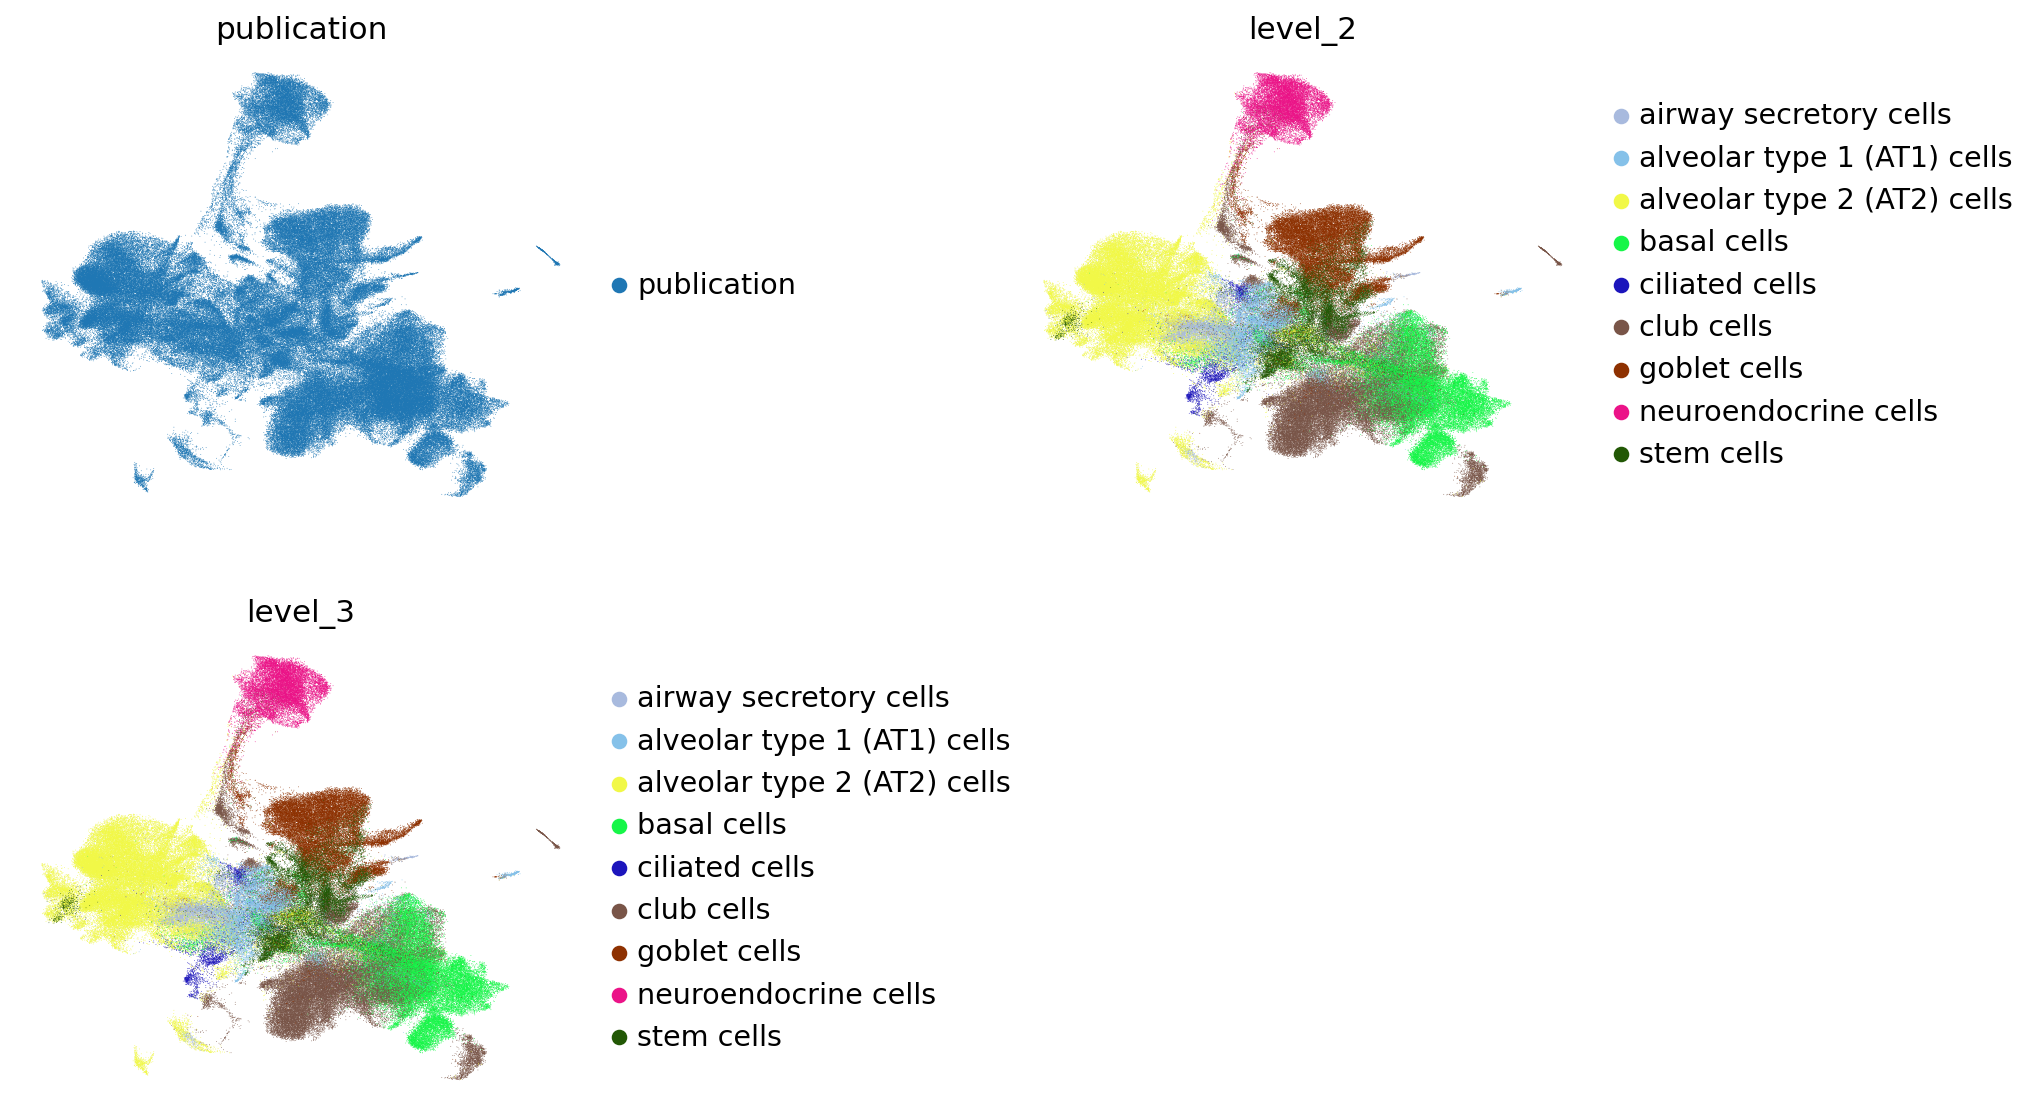

In [42]:
sc.pl.umap(embd, color=["publication", "level_2", "level_3"], 
                            wspace = 0.6, ncols=2, frameon=False, show=True)

/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


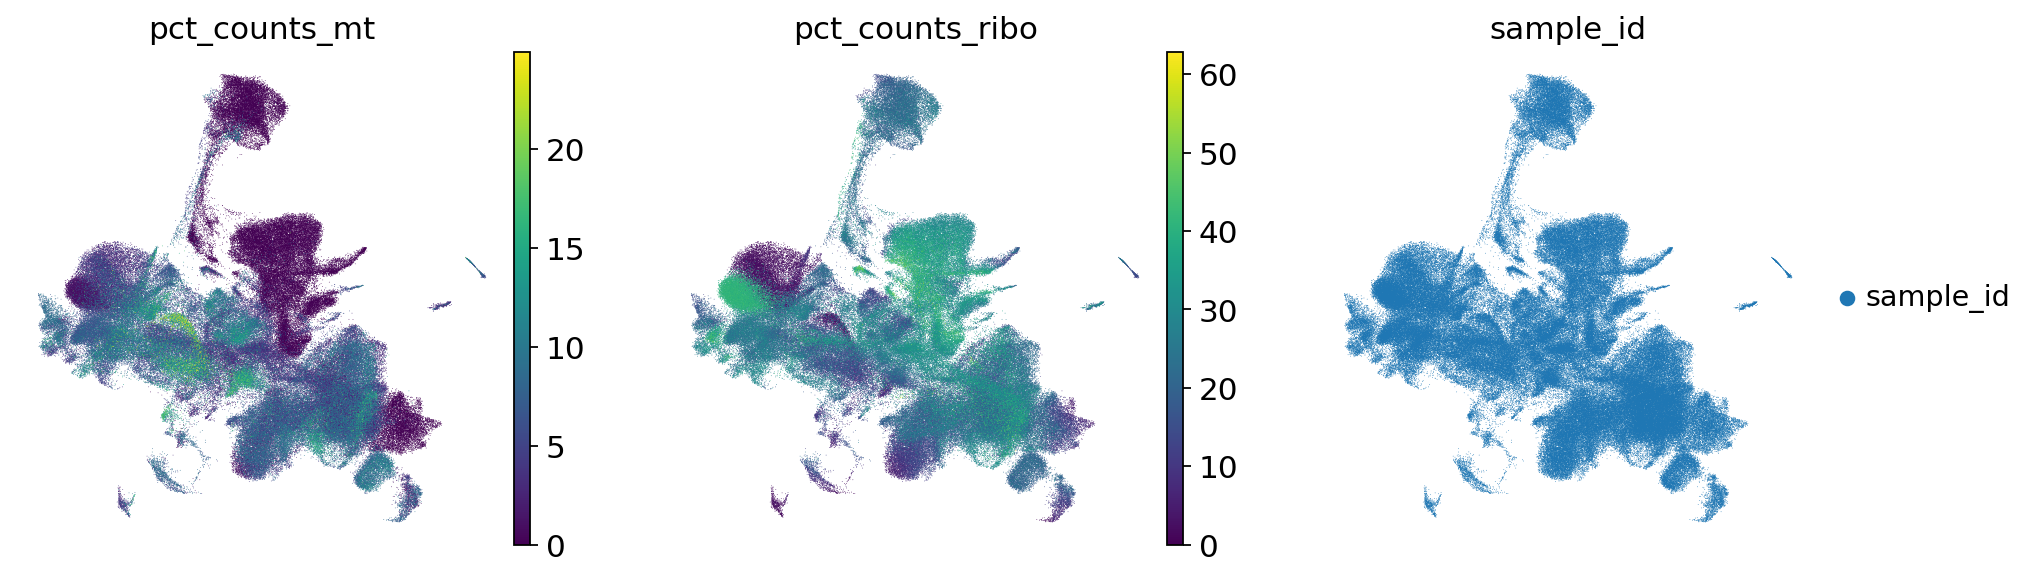

In [43]:
sc.pl.umap(embd, color=['pct_counts_mt',  'pct_counts_ribo', 'sample_id'], 
                            ncols=3, frameon=False, show=True)

/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


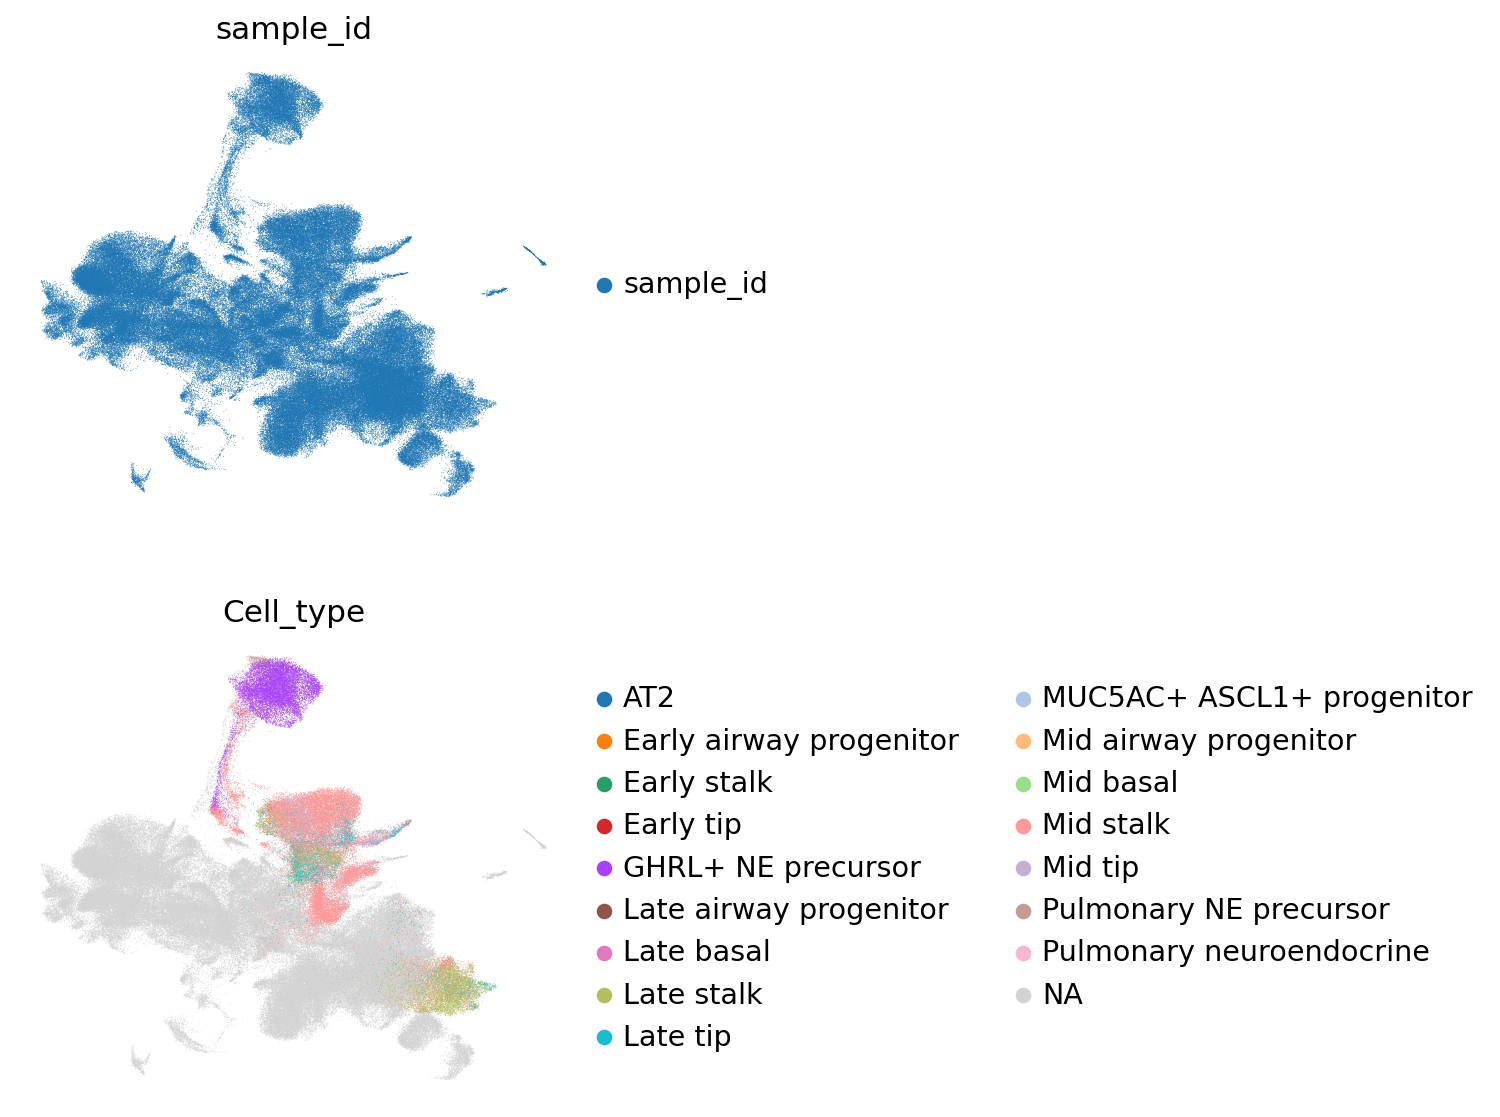

In [44]:
sc.pl.umap(embd, color=['sample_id', 'Cell_type'], 
                            ncols=1, frameon=False, show=True)

/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


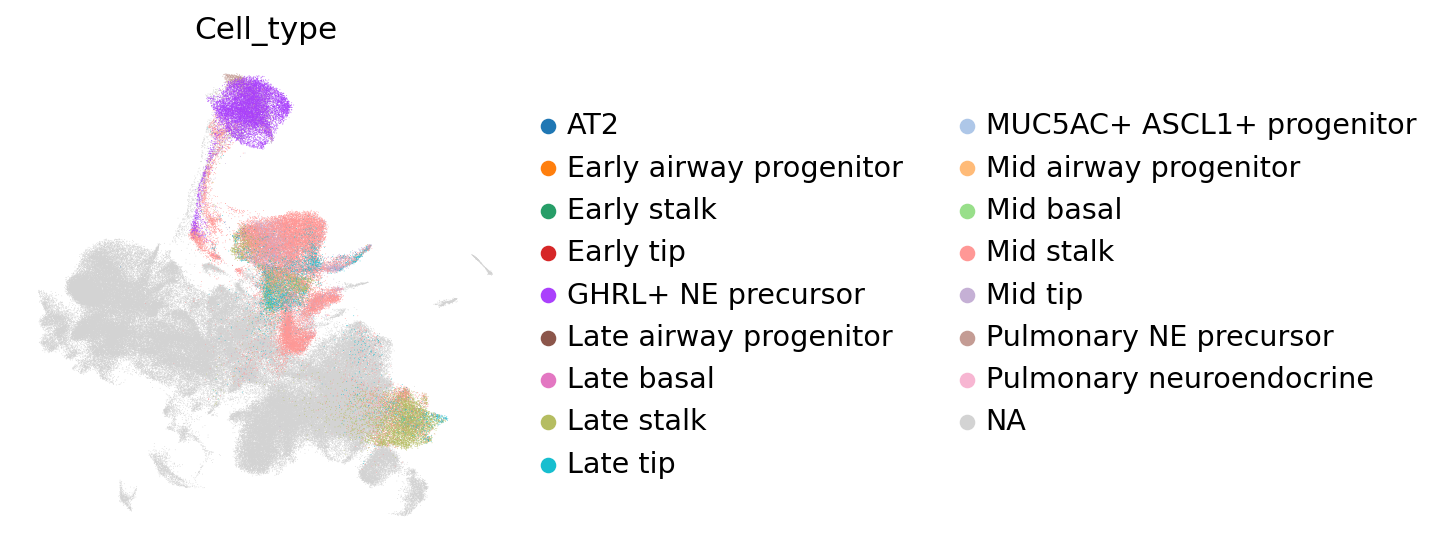

In [45]:
sc.pl.umap(embd, color=['Cell_type'], 
                            ncols=1, frameon=False, show=True)

/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/theislab/l_zadeh/.conda/envs/scarches_latest/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


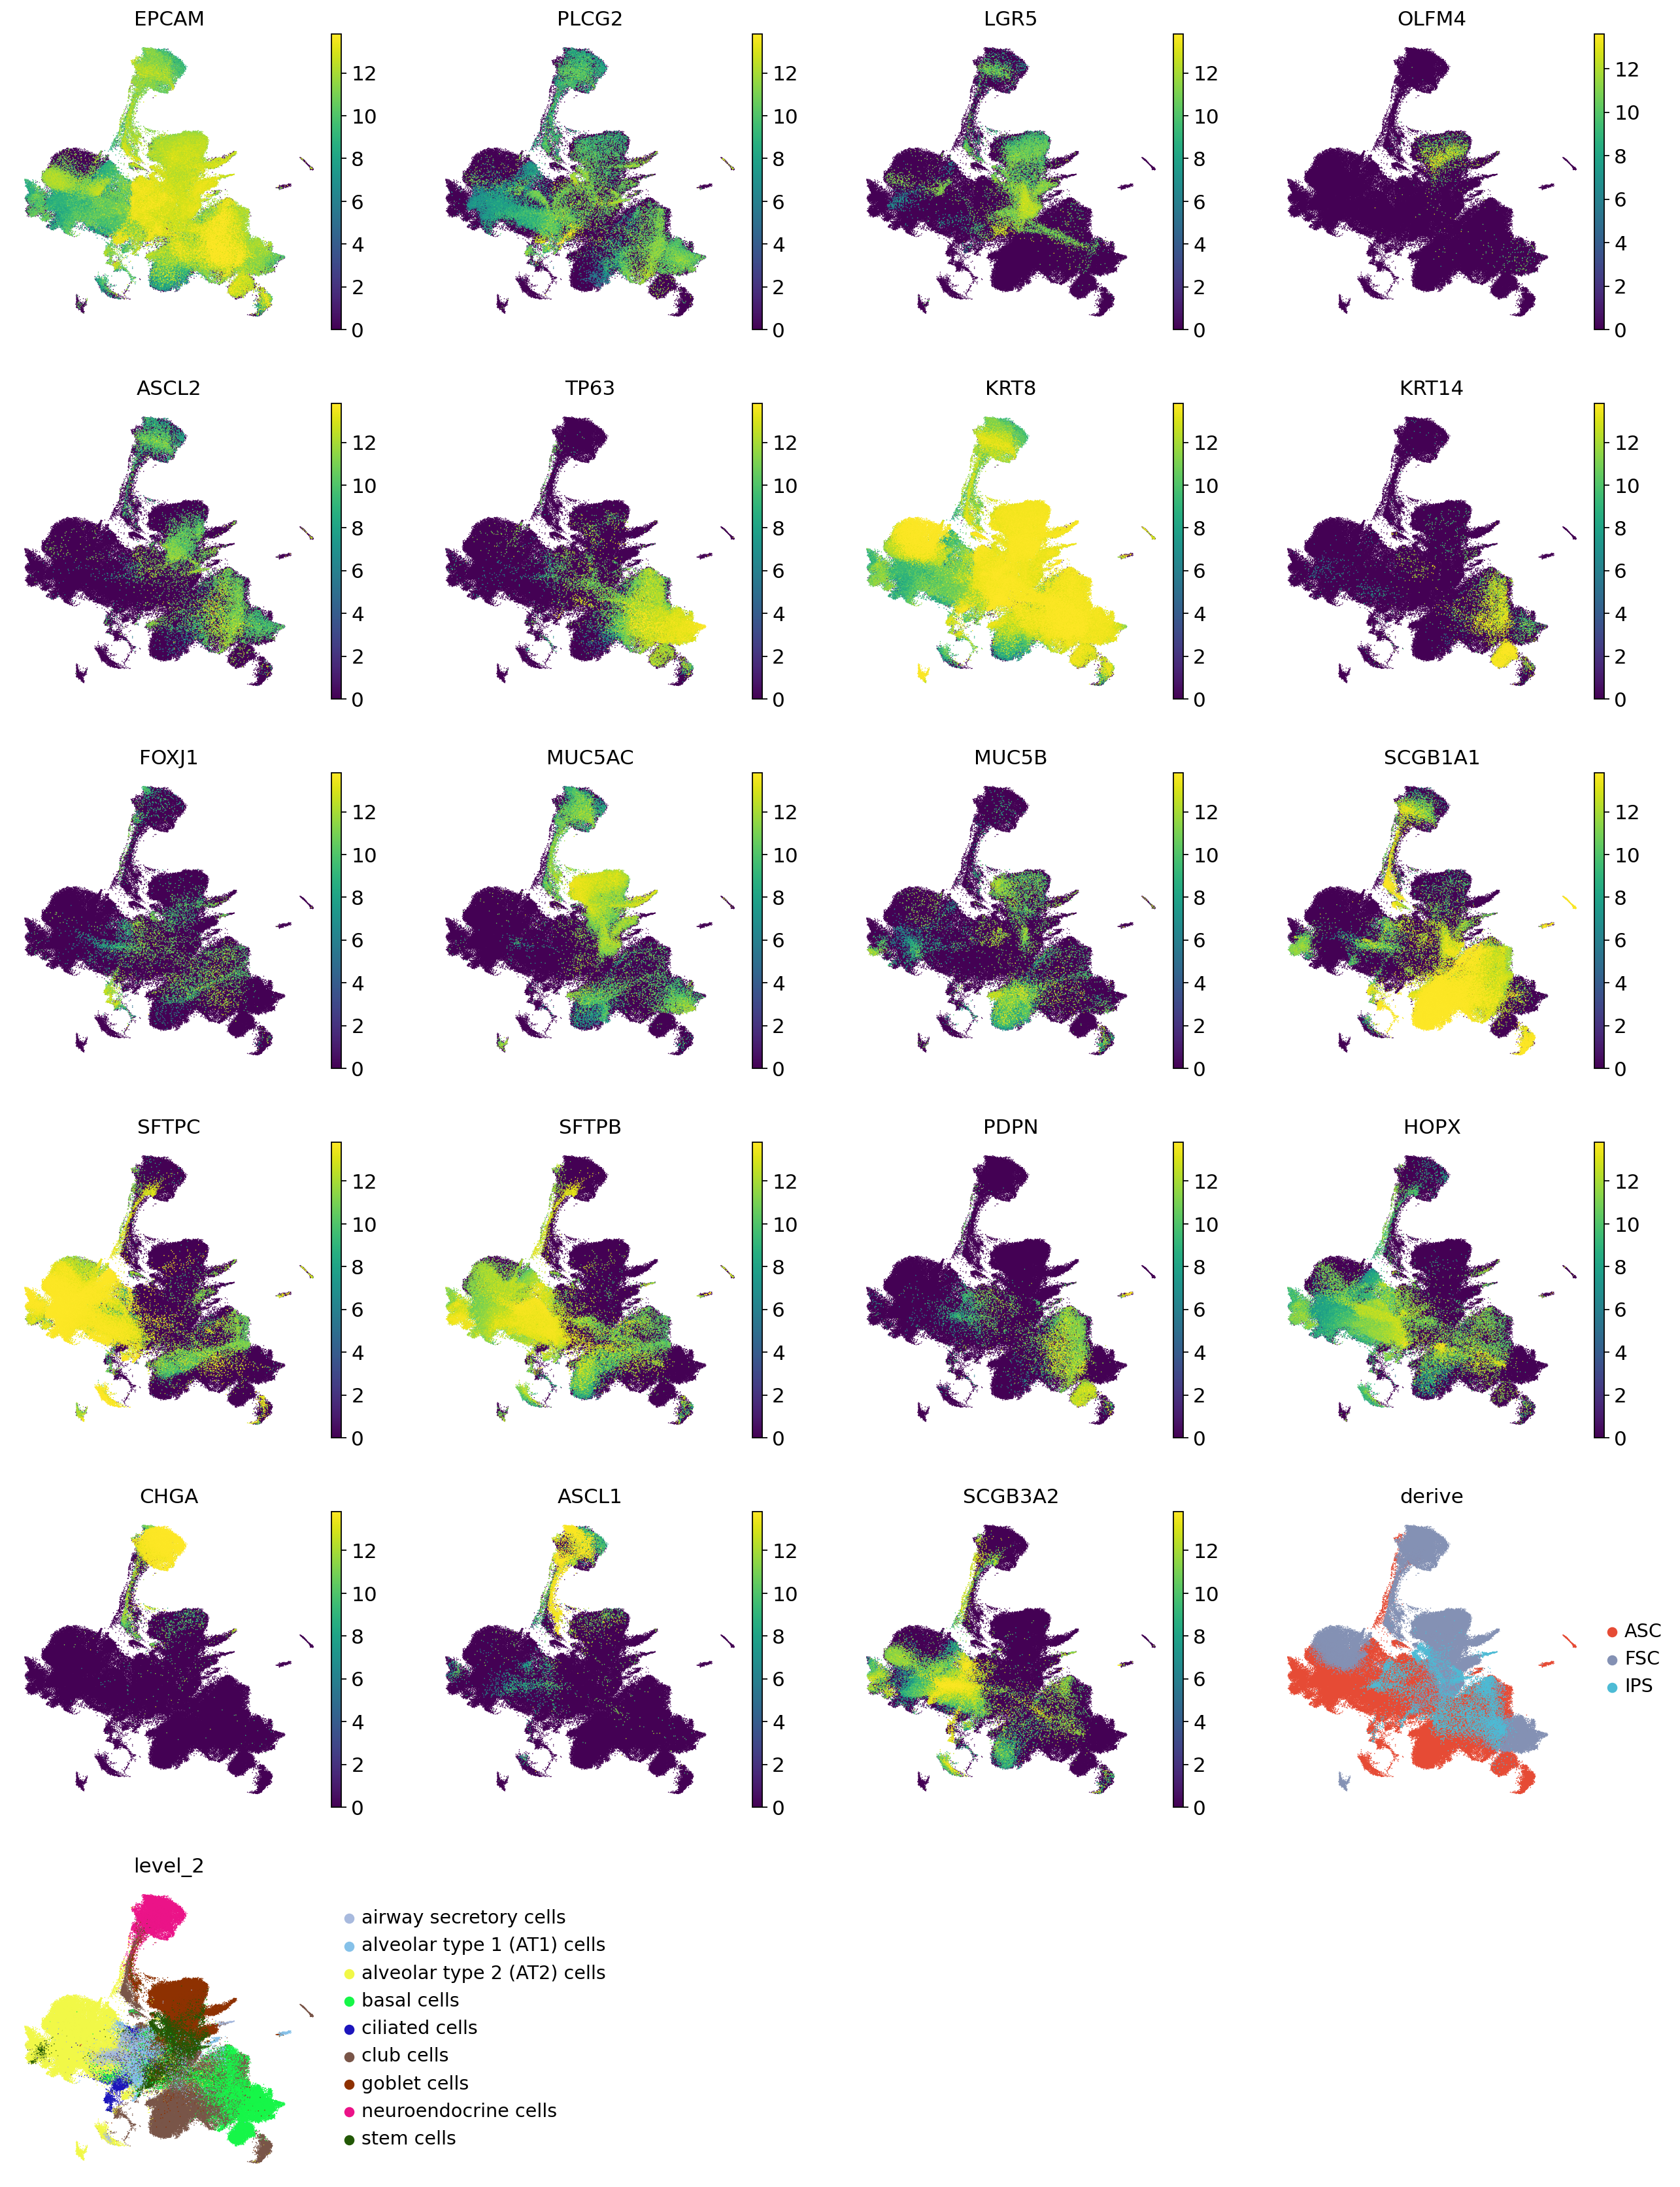

In [49]:
# for slides
sc.pl.umap(embd, color=markers+['derive','level_2',], size = 2,
                            ncols=4, frameon=False, show=True,
          save = 'lungorganoid_old_integration_ann_lungmarkers_mdata.png')

In [ ]:
embd.obs.protocol.value_counts()

In [ ]:
sc.pl.umap(embd, color=['time', 'derive', 'tech_detail'], 
                            ncols=2, frameon=False, show=True)

In [ ]:
embd.obs['conditions_combined'] = embd.obs.conditions_combined.astype('str')
embd.obs['main_cells'] = embd.obs.main_cells.astype('str')
embd.obs['protocol'] = embd.obs.protocol.astype('str')
embd.obs['molecular'] = embd.obs.molecular.astype('str')
embd.obs['gel'] = embd.obs.gel.astype('str')

In [ ]:
embd.write('embeddings/epithelial_lung_organoid_latent__model__scpoli_integration_lung_organoid_sampelD_as_batch_3kFeatures.h5ad')